In [2]:
from google.colab import drive
drive.mount('/content/drive')
paths = '/content/drive/MyDrive/Pytorch_Projects/Project_4/data/'

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary # Visualize the model layers and number of parameters
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam # Adam Optimizer
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import os
from tqdm import tqdm
print(device)

cuda


In [4]:
train_df =pd.read_csv(paths+"train.csv")
val_df = pd.read_csv(paths+"val.csv")
train_df["image:FILE"] = train_df["image:FILE"].apply(lambda x: paths+"/"+x)
val_df["image:FILE"] = val_df["image:FILE"].apply(lambda x: paths+"/"+x)
print(train_df.shape)
print(val_df.shape)

(1034, 2)
(133, 2)


In [5]:
print(train_df['category'].unique())
print(train_df['category'].value_counts())
print(val_df['category'].value_counts())
print(train_df['category'].unique())
data_df = pd.concat([train_df, val_df], ignore_index=True)

[0 1 2]
category
2    348
1    345
0    341
Name: count, dtype: int64
category
2    45
0    44
1    44
Name: count, dtype: int64
[0 1 2]


In [6]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [7]:
class CustomImageDataset(Dataset):
  def __init__(self,dataframe,transform):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(self.dataframe['category']).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx,0]
    label = self.labels[idx]
    image=Image.open(img_path)
    if self.transform:
      image =(self.transform(image)/255.0).to(device)
    return image,label

In [8]:
train_dataset = CustomImageDataset(dataframe=train_df,transform=transform)
val_dataset = CustomImageDataset(dataframe=val_df,transform=transform)

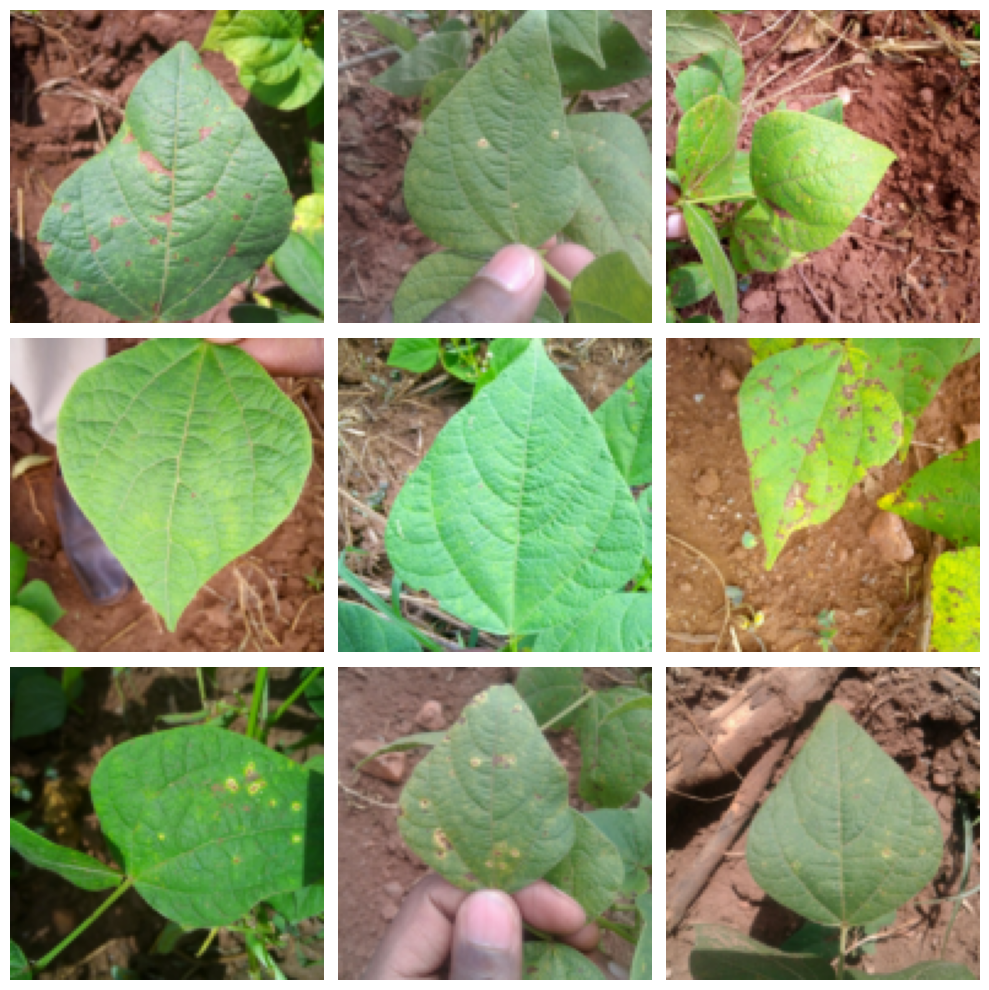

In [9]:
n_rows =3
n_cols =3

f,axarr = plt.subplots(n_rows,n_cols,figsize=(10,10))
for row in range(n_rows):
  for col in range(n_cols):
    image=train_dataset[np.random.randint(0,train_dataset.__len__())][0].cpu()
    axarr[row,col].imshow((image*255).squeeze().permute(1,2,0))
    axarr[row,col].axis('off')
plt.tight_layout()
plt.show()

In [10]:
LR = 1e-3
BATCH_SIZE = 4
EPOCHS = 15

In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
googlenet_model = models.googlenet(weights='DEFAULT')
for param in googlenet_model.parameters():
  param.requires_grad = True

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 178MB/s]


In [13]:
num_classes = len(data_df["category"].unique())
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [14]:
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss
optimizer = Adam(googlenet_model.parameters(), lr=LR) # Adam optimizer

In [ ]:
total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0

  for (inputs, labels) in train_loader:
    optimizer.zero_grad()
    outputs = googlenet_model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}%')
  print()

In [ ]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, (input, labels) in enumerate(test_loader):

    prediction = googlenet_model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/val_dataset.__len__())*100, 2)}%")

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].set_title('Training Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()
plt.show()